In [23]:
import pickle
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import cifar10
from main import plot_9images

Activation function is Sigmoid function
$$f(x)=Sigmoid(x)=\frac{1}{1+e^{-x}}$$
For each neuron j in the layer feedforward neural networks input is $\bf{x}$$=(x_1;x_2;...;x_n)$, connection weight is $\bf{w}$$=(w_1;w_2;...;w_n)$, output is $y_j$ .
$$y_j=f(\sum_{i}w_ix_i-\theta_i)$$

In [17]:
def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

def dsigmoid(y):
    return y*(1-y)

def forward(x, w, b):
    y = np.dot(w.T, x)+b
    out = sigmoid(y)
    return out 

For train case ($x_k, y_k$) assume neural network output is $\widehat{y}_{k}=(\widehat{y}_{1}^k, \widehat{y}_{2}^k, ...,\widehat{y}_{l}^k)$
case ($x_k, y_k$) in the network error is $$E_k=\sum_{j=1}^{l}{(\widehat{y}_{j}^k-y_{j}^k)} \tag{1-1}$$  
Using **gradient descent** method adjust weight $w$, for the error $E_k$, given the learning rate $\eta$,
$$\Delta w_{hj}=-\eta \frac{\partial{E_k}}{\partial{w_{hj}}}$$
output layer to hidden layer **gradient** is
$$\begin{eqnarray*} 
g_j & = &-\frac{\partial{E_k}}{\partial{\widehat{y}_{j}^k}}\frac{\partial{\widehat{y}_{j}^k}}{\partial{\beta_{j}}} \\
 &  = & \widehat{y}_{j}^k(1-\widehat{y}_{j}^k)(y_{j}^k-\widehat{y}_{j}^k)
\end{eqnarray*} \tag{1-2}$$


In [18]:
def ANN(train_data, train_labels, input_dim, hidden_dim, output_dim):

    print("hidden_dim is : ", hidden_dim)
    
    num_train_data = len(train_data)
    
    # w1 shape is (1024, h_dim)
    w1 = np.random.randn(input_dim, hidden_dim)*1e-2
    # b1 shape is (h_dim, 1)                       
    b1 = np.zeros( hidden_dim )                                                
    # w2 shape is (h_dim, 10)
    w2 = np.random.randn(hidden_dim, output_dim)*1e-2                       
    # b2 shape is (10, 1)
    b2 = np.zeros( output_dim )                                                
    
    input_learningrate = 0.4
    hidden_learningrate = 0.4
    
    for k in range(3):
        input_learningrate *= 0.5
        hidden_learningrate *= 0.5
        for i in range(num_train_data):
            # Forward
            # train_data[i].shape is (1024, 1)
            # hidden_out shape is (hidden_dim, 1)
            hidden_out = forward(train_data[i], w1, b1)                            
            #output shape is (10, 1)
            output = forward(hidden_out, w2, b2)
        
            # formula 1-1
            # error shape is (10, 1)
            error = train_labels[i]-output                             
            #formula 1-2
            # w2_gradient shape is (10, 1)
            w2_gradient = error*dsigmoid(output)                                     
            #formula 1-3
            # w1_gradient shape is (hidden_dim, 1)
            w1_gradient = np.dot(w2, w2_gradient)*dsigmoid(hidden_out) 
            #Update w2 
            for j in range(output_dim):
                w2[:,j] += input_learningrate*w2_gradient[j]*hidden_out
            #Update w1
            for j in range(hidden_dim):
                w1[:,j] += hidden_learningrate*w1_gradient[j]*train_data[i]
            
            #Update threshold
            b2 += hidden_learningrate*w2_gradient
            b1 += input_learningrate*w1_gradient
            
    return w1, b1, w2, b2    


In [19]:
def train(images, one_hot_labels, images_test, cls_idx_test):
    num_images = len(images)
    img_size = 32 
    num_test = len(images_test)
    
    feature_vectors = np.zeros(shape=[num_images, img_size*img_size], dtype=float)
    
    feature_vectors = get_gray_feature(images)
    
    input_dim = 1024
    output_dim = 10
    
    w1_best, b1_best, w2_best, b2_best = ANN(feature_vectors, one_hot_labels, input_dim, 64, output_dim)
    test_idx = np.zeros(num_test, dtype=int)
    test_idx = predict(images_test, w1_best, b1_best, w2_best, b2_best)

    accuracy_rate_best = np.array((test_idx == cls_idx_test)).mean() 
    hidden_dim_best = 64

    print("hidden_dim %d accuracy_rate is %f, best is %f" % (64, accuracy_rate_best, accuracy_rate_best))
    x_la = [64]
    y_la = [accuracy_rate_best]
    
    tmp_idx = np.zeros(num_test, dtype=int)
    for hidden_dim in range(64+32, 1025, 32):
        w1, b1, w2, b2 = ANN(feature_vectors, one_hot_labels, input_dim, hidden_dim, output_dim)
        tmp_idx = predict(images_test, w1, b1, w2, b2)
        tmp_accuracy_rate = np.array((tmp_idx == cls_idx_test)).mean()
        
        x_la.append(hidden_dim)
        y_la.append(tmp_accuracy_rate)
        
        if tmp_accuracy_rate > accuracy_rate_best:
            w1_best = w1
            b1_best = b1
            w2_best = w2
            b2_best = b2
            accuracy_rate_best = tmp_accuracy_rate
            hidden_dim_best = hidden_dim
        
        print("hidden_dim %d accuracy_rate is %f, best is %f" % (hidden_dim, tmp_accuracy_rate, accuracy_rate_best))
    
    plt.figure()
    plt.plot(x_la, y_la)
    plt.xlabel('number of hidden layer')   
    plt.ylabel('accuracy_rate')     
    print("accuracy_rate_best is:", accuracy_rate_best)
    print("hidden_dim_best is:", hidden_dim_best)    
    
    return w1_best, b1_best, w2_best, b2_best

In [20]:
def predict(images, w1, b1, w2, b2):
    # Return a Numpy ndarray with the length of len(images).
    # e.g. np.zeros((len(images),), dtype=int) means all predictions are 'airplane's
    img_size = 32
    num_images = len(images)
    
    feature_vectors = np.zeros(shape=[num_images, img_size*img_size], dtype=float)
    feature_vectors = get_gray_feature(images)    
    
    ann_idx = np.zeros(num_images, dtype=int)
    for i in range(num_images):
        hidden_out = forward(feature_vectors[i], w1, b1)
        output = forward(hidden_out, w2, b2)
        ann_idx[i] = np.argmax(output)
    
    return ann_idx

In [21]:
def get_gray_feature(images):
    
    num_images = len(images)
    img_size = 32
    
    # Data reduction
    # Convert an RGB image into Grayscale image 
    gray_images = np.dot(images[...,:3], [0.299, 0.587, 0.114])
    feature_vectors = np.zeros(shape=[num_images, img_size*img_size], dtype=float)
    
    # Get feature_vectors
    for i in range(num_images):
        feature_vectors[i] = gray_images[i].ravel()
        
    return feature_vectors

Loading data: data/cifar-10-batches-py/batches.meta
Loading data: data/cifar-10-batches-py/data_batch_1
Loading data: data/cifar-10-batches-py/data_batch_2
Loading data: data/cifar-10-batches-py/data_batch_3
Loading data: data/cifar-10-batches-py/data_batch_4
Loading data: data/cifar-10-batches-py/data_batch_5
Loading data: data/cifar-10-batches-py/test_batch


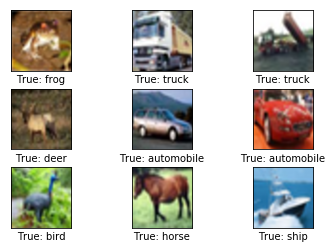

hidden_dim is :  64
hidden_dim 64 accuracy_rate is 0.358600, best is 0.358600
hidden_dim is :  96
hidden_dim 96 accuracy_rate is 0.354900, best is 0.358600
hidden_dim is :  128
hidden_dim 128 accuracy_rate is 0.361200, best is 0.361200
hidden_dim is :  160
hidden_dim 160 accuracy_rate is 0.360500, best is 0.361200
hidden_dim is :  192
hidden_dim 192 accuracy_rate is 0.362400, best is 0.362400
hidden_dim is :  224
hidden_dim 224 accuracy_rate is 0.365000, best is 0.365000
hidden_dim is :  256
hidden_dim 256 accuracy_rate is 0.359900, best is 0.365000
hidden_dim is :  288
hidden_dim 288 accuracy_rate is 0.360300, best is 0.365000
hidden_dim is :  320
hidden_dim 320 accuracy_rate is 0.356900, best is 0.365000
hidden_dim is :  352
hidden_dim 352 accuracy_rate is 0.365000, best is 0.365000
hidden_dim is :  384
hidden_dim 384 accuracy_rate is 0.364100, best is 0.365000
hidden_dim is :  416
hidden_dim 416 accuracy_rate is 0.361400, best is 0.365000
hidden_dim is :  448
hidden_dim 448 accuracy

NameError: name 'random' is not defined

In [22]:
class_names = cifar10.load_class_names()
images_train, cls_idx_train, labels_train = cifar10.load_training_data()
images_test, cls_idx_test, labels_test = cifar10.load_test_data()

#Plot the first 9 training images and labels
plot_9images(images=images_train[0:9], cls_idx_true=cls_idx_train[0:9],all_cls_names=class_names, smooth=True)

# Build your predictor
w1, b1, w2, b2 = train(images_train, labels_train, images_test, cls_idx_test)
    
# Visualize your prediction
samples = random.sample(range(len(images_test)), 9)
plot_9images(images=images_test[samples], cls_idx_true=cls_idx_test[samples],
             cls_idx_pred=predict(images_test[samples], w1, b1, w2, b2), all_cls_names=class_names, smooth=True)
print(f'\nAccuracy: {(predict(images_test, w1, b1, w2, b2) == cls_idx_test).mean() * 100}%\n')
